In [2]:
import pandas as pd

root_dir = ''
image_dir = 'final_cxr_dataset/'

df = pd.read_csv('final_dataset.csv')

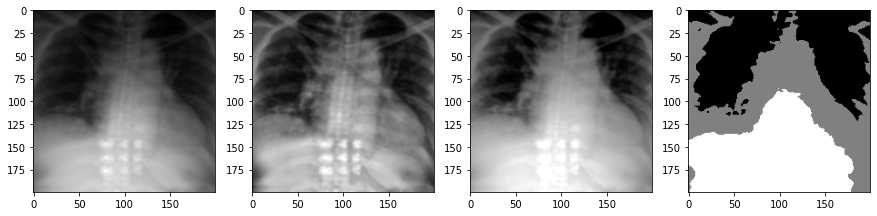

In [67]:
import numpy as np
from skimage import io, filters, exposure
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
import skimage.exposure as expo

length = 200
index = 88

current = df.iloc[index]
img_loc = root_dir + image_dir + current['filename']

coarse_mask = img_as_ubyte(io.imread('coarse_mask.png', as_gray=True))

try:
    img = img_as_ubyte(io.imread(img_loc, as_gray=True))
    y_len, x_len = img.shape
    
    if y_len > x_len:    # height > width
        img = resize(img, [ round(length*y_len/x_len), length ])
        y_len = img.shape[0]
        crop_length = y_len - length
        img = img[ :y_len-crop_length , : ]    # crop from bottom
        
    elif y_len < x_len:    # height < width
        
        img = resize(img, [ length, round(length*x_len/y_len) ])
        x_len = img.shape[1]
        crop_length = x_len - length
        half_crop = crop_length//2
        img = img[ : , half_crop:x_len-half_crop ]    # crop on left and right
        
        if img.shape[0] != img.shape[1]:
            img = img[ : , :length ]    # make sure image is square
        
    else:    # height == width
        img = resize(img, [ length, length ])
    
    img = filters.gaussian(img)
    
    #contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    #histogram eq
    img_eq = exposure.equalize_hist(img_rescale)
    
    #adaptive histogram eq
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.01)
    
    # coarse mask -> thresholding
    inverted = ~img_as_ubyte(img)
    thresh = filters.threshold_multiotsu(img_eq)
    regions = np.digitize(img_eq, bins=thresh)
    
    binary1 = ~(img >= thresh[0])
    #plt.imshow(binary1, cmap="gray")
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))
    ax0.imshow(img, cmap="gray")
    ax1.imshow(img_adapteq, cmap="gray")
    ax2.imshow(img_eq, cmap="gray")
    ax3.imshow(regions, cmap="gray")
    
except FileNotFoundError:
    print(f'{img_loc} not found.')

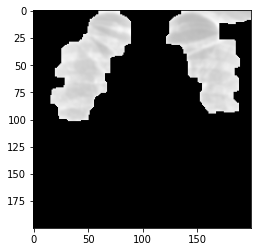

In [68]:
from skimage.morphology import square, dilation, erosion, opening, closing, remove_small_objects, remove_small_holes
#coarse mask -> thresholding
#masked = ~(img_as_ubyte(img) * coarse_mask)
#thresh = flt.threshold_yen(masked)
#binary1 = masked <= thresh

# thresholding -> coarse mask
#thresh = flt.threshold_yen(img_as_ubyte(img))
#masked = ~(img_as_ubyte(img) * coarse_mask)
#binary2 =  masked <= thresh

kernel = square(7)
op = opening(binary1, kernel)#select binary here
#op = dilation(remove_small_objects(erosion(op, kernel), 200), kernel)
mask = closing(op, kernel)
mask = remove_small_objects(mask, 1000)
#mask = remove_small_holes(mask, 1200)
final1 = img * mask

plt.imshow(final1, cmap=plt.cm.gray)

In [910]:
output_dir = 'preprocessed/'
img_dir = 'masked_images/'
mask_dir = 'masks/'
filename = f'{index}.png'

try:
    io.imsave(f'{output_dir}{img_dir}{filename}', img_as_ubyte(final1))
    io.imsave(f'{output_dir}{mask_dir}{filename}', img_as_ubyte(mask))
    print('Success')
finally:
    print('DONE')

Success
DONE
